# Initialize

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from functools import partial

bp = '/data/khodadaa/mslr/MSLR-WEB30K/Fold1'
r = 0.1

In [325]:
# convert 2 qid:13 1:2 2:0 3:2 ... --> {'rel': 2, 'qid': 13, 1:2, 2:0, 3:2, ...} then build a Dataframe based on it 
def split_fea_name_val(df: pd.DataFrame):
    def func(c):
        fe, val = c.split(':', 1)    
        return "{}: {}".format(fe, val)
    dict_df = df.apply(lambda x: ast.literal_eval("{{'rel': {}, 'qid': {}, {}}}".format(
        x[0], x[1].split(':',1)[1], ', '.join(x[2:].apply(lambda cl: func(cl))))), axis=1)
    return pd.DataFrame(index=dict_df.index, data=list(dict_df.values))

def adjust_features(df: pd.DataFrame, cols: list):
    for i, v in enumerate(cols):
        if i == 0:
            continue
        df[v] = df[v].str.replace(str(v-1)+':', str(i-1)+':')
    return df

def sort_qid(df: pd.DataFrame):
    df[['qid-str', 'qid']] = df[1].str.split(':', expand=True)
    df['qid'] = df.qid.astype(int)

    df.sort_values(by='qid', inplace=True)
    df.drop(columns=['qid-str', 'qid'], inplace=True)
    
def split_X_y_qid(df: pd.DataFrame):
    df = split_fea_name_val(df)
    X = df[list(range(1,df.columns[-1]))]
    y = df['rel']
    qid = df['qid']
    return X, y, qid

def plot_popularity_distribution(df: pd.DataFrame, start_index=0, end_index=None):
    pops = list(df['135'])
    pops.sort(reverse=True)
    end_index = end_index if end_index is not None else len(pops)
    plt.plot(pops[start_index: end_index])
    plt.ylabel('Popularity')
    plt.show()

# MSLR Data Preparation (merge train, validation and test sets)

In [2]:
%%time
train_df = pd.read_csv(bp + '/train.txt', header=None, sep='\s+')
valid_df = pd.read_csv(bp + '/vali.txt', header=None, sep='\s+')
test_df = pd.read_csv(bp + '/test.txt', header=None, sep='\s+')    
print(train_df.shape, valid_df.shape, test_df.shape)
print(train_df.shape[0]+ valid_df.shape[0]+test_df.shape[0])

(2270296, 138) (747218, 138) (753611, 138)
3771125
CPU times: user 2min 38s, sys: 10.8 s, total: 2min 49s
Wall time: 2min 34s


In [3]:
def map_column_to_score():
    mapping = {}
    corpus_type = ['bdy', 'anc', 'ttl', 'url', 'wdc']
    metric = ['CovQTNum', 'CovQTR', 'StrmLen', 'idf', 'sum-tf', 'min-tf', 'max-tf', 'mean-tf', 'var-tf', 
          'sum-StrLen-norm-tf', 'min-StrLen-norm-tf', 'max-StrLen-norm-tf', 'mean-StrLen-norm-tf', 'var-StrLen-norm-tf',
          'sum-tfidf', 'min-tfidf', 'max-tfidf', 'mean-tfidf', 'var-tfidf', 'boolModel', 'VecSpacMod', 'BM25',
          'LMIR.ABS', 'LMIR.DIR', 'LMIR.JM']
    i = 0    
    for m in metric:
        for ct in corpus_type:
            i += 1
            mapping[i] = m + '({})'.format(ct)

    for e in ['NumSlshURL', 'url-len', 'inlink-num', 'outlink-num', 'PageRank', 'SiteRank', 'QualScore',
              'QualScore2', 'QUrlCliCnt', 'UrlCliCnt', 'UrlDwellTime']:
        i += 1
        mapping[i] = e 
    return mapping

In [4]:
%%time
df_orig = train_df.append(valid_df, ignore_index=True).append(test_df, ignore_index=True)
df_orig.shape

CPU times: user 47.2 s, sys: 10.6 s, total: 57.8 s
Wall time: 31.1 s


In [ ]:
%%time
df = split_fea_name_val(df_orig)
df.sort_values(by=['qid', 'rel'], inplace=True)

In [8]:
%%time
df.to_csv('/data/khodadaa/mslr/MSLR-WEB30K/mslr-web30k.csv')
df_rn = df.rename(columns=map_column_to_score())
df_rn.to_csv('/data/khodadaa/mslr/MSLR-WEB30K/mslr-web30k-colname.csv')

CPU times: user 16min 23s, sys: 46.8 s, total: 17min 10s
Wall time: 16min 28s


# MSLR Save to .npz (Split qid, relevance and features as save them as npz)

In [286]:
%%time

# output_postfix = 'reduced'
bp, dirname = '/data/khodadaa/mslr/MSLR-WEB10K/', 'mslr-web10k'
# bp, dirname = '/data/khodadaa/mslr/MSLR-WEB30K/', 'mslr-web30k'
# bp, dirname = '/data/khodadaa/mslr/Gov/Feature_min/2003_hp_dataset/', '2003_hp_dataset'

cols = None
# cols = list(range(1,6)) #+ list(range(11,26)) + list(range(71,76)) + list(range(105, 132))
# cols = [0, 1] + list(map(lambda x: x+1, keep))

for fn in range(1,6):
    fold = 'Fold' + str(fn)
    npz_dict = {}
    for gr in ['train', 'vali', 'test']:
        df = pd.read_csv(bp + '{}/{}.txt'.format(fold, gr), sep='\s+', header=None, usecols=cols)
        print(fold, gr, df.shape)
        
        X, y, qid = split_X_y_qid(df)
        print('Split done!')
        npz_dict['X_'+gr] = X.values
        npz_dict['y_'+gr] = y.values
        npz_dict['qid_'+gr] = qid.values
    np.savez(file=bp+dirname+fold, **npz_dict)
        
        
#         sort_qid(df)
#         df = adjust_features(df, cols)
#         df.to_csv(bp + '{}/{}_{}.csv'.format(fold, gr, output_postfix), index=False, sep=' ', header=False)

Fold1 train (723412, 138)
Split done!
Fold1 vali (235259, 138)
Split done!
Fold1 test (241521, 138)
Split done!
Fold2 train (716683, 138)


KeyboardInterrupt: 

# MSLR BM25

In [434]:
%%time
bm25_df = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/mslr-web30k.csv', index_col=0)

/nfs/stak/users/khodadaa/miniconda3/envs/db/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 1min 32s, sys: 15.1 s, total: 1min 47s
Wall time: 1min 18s


In [463]:
%%time
bm25_gp = bm25_df.groupby('qid')
for name, group in bm25_gp:
    bm_gp_rels = sorted(list(group['rel']), reverse=True)
    print(bm_gp_rels)
    bm_gp_sorted = group.sort_values(by='110', ascending=False)    
    bm_gp_sorted['rel'] = bm_gp_rels
    print(bm_gp_sorted.loc[83, ['qid', 'rel', '110']])
    new_rels = pd.Series(index=bm_gp_sorted.index, data=bm_gp_rels)
    bm25_df
    print(bm25_df.loc[83, ['qid', 'rel', '110']])
    input()

[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
qid     1.000000
rel     3.000000
110    23.144228
Name: 83, dtype: float64
qid     1.000000
rel     1.000000
110    23.144228
Name: 83, dtype: float64


KeyboardInterrupt: 

# Build Custom Training Sets

In [298]:
data = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/train.txt', sep='\s+', header=None)

data2 = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/vali.txt', sep='\s+', header=None)

data3 = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/test.txt', sep='\s+', header=None)

In [ ]:
%%time
mslr_data = data.append(data2, ignore_index=True).append(data3, ignore_index=True)

In [301]:
uniq_qids = mslr_data[1].unique()
uniq_qids[:10]

array(['qid:1', 'qid:6', 'qid:11', 'qid:16', 'qid:21', 'qid:26', 'qid:31',
       'qid:36', 'qid:41', 'qid:46'], dtype=object)

In [359]:
from random import shuffle
shuffle(uniq_qids)
uniq_qids[:10]

array(['qid:464', 'qid:25952', 'qid:9372', 'qid:5243', 'qid:7759',
       'qid:8863', 'qid:17692', 'qid:23849', 'qid:2849', 'qid:17155'],
      dtype=object)

In [386]:
train_size = int(r*len(uniq_qids))
valid_size = int(r*len(uniq_qids))
new_train_qids = uniq_qids[0 : train_size]
new_valid_qids = uniq_qids[train_size : train_size+valid_size]
new_test_qids = uniq_qids[train_size+valid_size :]
new_train_data = mslr_data[mslr_data[1].isin(new_train_qids)]
new_valid_data = mslr_data[mslr_data[1].isin(new_valid_qids)]
new_test_data = mslr_data[mslr_data[1].isin(new_test_qids)]

nts0 = new_train_data.shape[0]+new_valid_data.shape[0]+new_test_data.shape[0]
print(new_train_data.shape[0]/nts0, new_valid_data.shape[0]/nts0, new_test_data.shape[0]/nts0)


new_train_data.to_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/{}-train.txt'.format(r), sep=' ', index=False, header=False)
new_valid_data.to_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/{}-vali.txt'.format(r), sep=' ', index=False, header=False)
new_test_data.to_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/{}-test.txt'.format(r), sep=' ', index=False, header=False)

0.10152487652888727 0.09878537571679538 0.7996897477543173


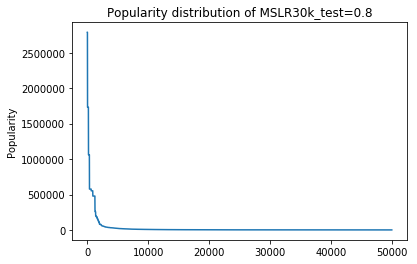

In [387]:
def plot_pops(df, start_index=0, end_index=None):
    pops = list(df[136])
    pops = list(map(lambda x: int(x[4:]), pops))
    pops.sort(reverse=True)    
    end_index = end_index if end_index is not None else len(pops)
    plt.plot(pops[start_index: end_index])
    plt.ylabel('Popularity')
    plt.title('Popularity distribution of MSLR30k_test={}'.format(1-2*r))
    plt.show()

plot_pops(new_test_data, 0, 50000)

# Learn to Rank Build Model

In [596]:
import pyltr

stp_after = 10

In [597]:
%%time
with open(bp + '/{}-train.txt'.format(r)) as trainfile, \
     open(bp + '/{}-vali.txt'.format(r)) as valifile, \
     open(bp + '/{}-test.txt'.format(r)) as evalfile:
        TX, Ty, Tqids, _ = pyltr.data.letor.read_dataset(trainfile)
        VX, Vy, Vqids, _ = pyltr.data.letor.read_dataset(valifile)
        EX, Ey, Eqids, _ = pyltr.data.letor.read_dataset(evalfile)

CPU times: user 12min 5s, sys: 18.2 s, total: 12min 24s
Wall time: 12min 24s


In [390]:
metric = pyltr.metrics.NDCG(k=10)
monitor = pyltr.models.monitors.ValidationMonitor(
        VX, Vy, Vqids, metric=metric, stop_after=stp_after)
model = pyltr.models.LambdaMART(
        metric=metric,
        n_estimators=1000,
        learning_rate=0.02,
        max_features=0.5,
        query_subsample=0.5,
        max_leaf_nodes=10,
        min_samples_leaf=64,
        verbose=1)

In [ ]:
%%time
model.fit(TX, Ty, Tqids, monitor=monitor)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.1213       0.1149      286.24m      C:      0.1244 B:      0.1244 S:  0
    2       0.2470       0.1146      284.06m      C:      0.2387 B:      0.2387 S:  0
    3       0.2617       0.0234      282.60m      C:      0.2602 B:      0.2602 S:  0
    4       0.2721       0.0086      283.16m      C:      0.2687 B:      0.2687 S:  0
    5       0.2773       0.0037      282.73m      C:      0.2727 B:      0.2727 S:  0
    6       0.2748       0.0062      281.85m      C:      0.2794 B:      0.2794 S:  0
    7       0.2945       0.0091      282.28m      C:      0.2898 B:      0.2898 S:  0
    8       0.3013       0.0090      282.36m      C:      0.2980 B:      0.2980 S:  0
    9       0.3001       0.0008      282.54m      C:      0.2994 B:      0.2994 S:  0
   10       0.3088       0.0127      283.60m      C:      0.3119 B:      0.3119 S:  0
   15       0.3478      -0.0010      283.54m      C: 

In [598]:
def get_frequency():
    test_df = pd.read_csv(bp + '/{}-test.txt'.format(r), sep='\s+', header=None)
    url_click_counts = test_df[136].str.replace('135:', '')
    url_click_counts = url_click_counts.astype(int)
    return url_click_counts.values
    
Epred = model.predict(EX)
# Epred = EX[:, 109] # To use BM25 [feature #110] as predictions
Efreq = get_frequency()
pd.DataFrame({'Eqids': Eqids, 'Ey':Ey, 'Epred':Epred, 'Efreq':Efreq}, 
                       columns=['Eqids', 'Efreq', 'Ey', 'Epred']).to_csv(
                        '{}/{}-lambda_preds_{}.csv'.format(bp, r, stp_after), index=False)

In [599]:
print('Random ranking:', metric.calc_mean_random(Eqids, Ey))
print('Our model:', metric.calc_mean(Eqids, Ey, Epred))

Random ranking: 0.19480186807845296
Our model: 0.2804544815589282


BM25 r = 0.01 & 
Random ranking: 0.19480186807845296 &
Our model: 0.2804544815589282

BM25 r = 0.1 & 
Random ranking: 0.1942467805983666 &
Our model: 0.2803232641245612

r= 0.1 &
Random ranking: 0.1942467805983666 &
Our model: 0.435723774309332

r = 0.01 &
Random ranking: 0.19480186807845296 & 
Our model: 0.3810724694511498

# Popularity = URL relevancy rate to qids

In this experiment we consider popularity of an answer to be the number of queries that it's relevant to. Using this new value for the frequency, we then plot our nDCG ove cache distributions.

In [2]:
def get_url_distribution(df: pd.DataFrame):
    dup_set = list(range(126, 134)) + [135]
    dup_set = list(map(lambda x: '{}'.format(x), dup_set))
    
    url_df = pd.DataFrame(index=df.index)    
    url_id = 1
    for name, group in df.groupby(dup_set):
        url_df.loc[group.index, 'id'] = url_id
        url_df.loc[group.index, 'count'] = group.shape[0] 
        url_df.loc[group.index, 'paired-qids'] = group['qid'].unique().shape[0]
        url_df.loc[group.index, 'relevant-qids'] = group.loc[group['rel'] > 0, 'qid'].unique().shape[0]
        url_id += group.shape[0]
    return url_df

In [1185]:
%%time

# from multiprocessing import  Pool, cpu_count
import resource
resource.RLIMIT_NPROC = 5

rnd_qid_frac = 0.5

def gen_pops_using_random_qid_subset(orig_df: pd.DataFrame, frac: float, dup_set):
    df = orig_df.copy(deep=True)
    uniq_qids = df['qid'].unique()
    rand_qid = np.random.choice(uniq_qids, size=int(frac*uniq_qids.shape[0]))
    for name, group in df.groupby(dup_set):
        df.loc[group.index, 'url-popularity'] = np.isin(group['qid'].unique(), rand_qid).shape[0]
    return df


def build_popularity(r, use_random_qid_subset=False):
    test_df = pd.read_csv(bp + '/{}-test.csv'.format(r), index_col=0)
    pred_df = pd.read_csv('{}/{}-lambda_preds_{}.csv'.format(bp, r, stp_after), 
                        dtype={'Eqids': str, 'Efreq': int, 'Ey': float, 'Epred': float})    
    
    dup_set = list(range(126, 134)) + [135]
    dup_set = list(map(lambda x: '{}'.format(x), dup_set))
    
    if not use_random_qid_subset:
        for name, group in test_df.groupby(dup_set):
            test_df.loc[group.index, 'url-popularity'] = group['qid'].unique().shape[0]

        test_df.to_csv(bp + '/{}-test_url_idpop.csv'.format(r), index=False)    
        pred_df['Efreq'] = test_df['url-popularity']
        pred_df.to_csv('{}/{}-lambda_preds_urlpop_{}.csv'.format(bp, r, stp_after), index=False)
    
    # Using random frac% of qids
    if use_random_qid_subset:
        rnd_test_df = gen_pops_using_random_qid_subset(test_df, frac=rnd_qid_frac, dup_set= dup_set)
        rnd_test_df.to_csv(bp + '/{}-test_url_idpop_rnd{}.csv'.format(r), rnd_qid_frac, index=False)
        pred_df['Efreq'] = rnd_test_df['url-popularity']
        pred_df.to_csv('{}/{}-lambda_preds_urlpop_rnd{}_{}.csv'.format(bp, r, rnd_qid_frac, stp_after), index=False)
        
def run(r):    
#     test_df = pd.read_csv(bp + '/{}-test.txt'.format(r), sep='\s+', header=None)
#     splited_test_df = split_fea_name_val(test_df)
#     print('Transformed test data format to dataframe.')
#     splited_test_df.to_csv(bp + '/{}-test.csv'.format(r))
#     build_popularity(r, use_random_qid_subset=False)
    build_popularity(r, use_random_qid_subset=True)

# run(0.1)
# run(0.01)

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 26.7 µs


# MSLR30K nDCG vs. Cache Perfect Distribution

In this section, we want to study *ideal* nDCG distribution when we dynamically change cache size. To find ideal nDCG for each cache size, we conisder the actual relevance values to be the values that is predicted by our model. Caches are built based on top i% popular answers. Popularity here is feature #135 which is *page click count*

In [424]:
from math import log2

def dcg(rels:list, k):
    dcg = 0.0
    for i in range(min(k, len(rels))):
        dcg += (2**rels[i] - 1) / log2((i+1) + 1)
    return dcg

In [425]:
%%time
mslr_df = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/mslr-web30k.csv', index_col=0)

/nfs/stak/users/khodadaa/miniconda3/envs/db/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 2min 8s, sys: 42 s, total: 2min 51s
Wall time: 1min 20s


In [170]:
%%time 
# calculating mean nDCG distribution over different cache sizes
k = 10
print('nDCG distribution for k=', k)

distrib_df = pd.DataFrame(index=mslr_df.qid.unique())
distrib_df.index.name = 'qid'

# calculating iDCGs
mslr_gp = mslr_df.groupby('qid')
idcg_ser = pd.Series(index=mslr_df.qid.unique())
for name, group in mslr_gp:
    rels_sorted = sorted(list(group['rel']), reverse=True)
    idcg = dcg(rels_sorted, k)
    idcg_ser[name] = idcg if idcg!=0.0 else 1.0
distrib_df['iDCG'] = idcg_ser    
    
mslr_df_sorted = mslr_df.sort_values(by='135', ascending=False)
for i in range(1, 101, 2):
    cache_size = int(mslr_df_sorted.shape[0] * i / 100)
    mslr_cache = mslr_df_sorted[: cache_size]
    mslr_cache_gps = mslr_cache.groupby('qid')
    ndcg_ser = pd.Series(index=mslr_df.qid.unique())
    for name, group in mslr_cache_gps:
        rels = list(group['rel'])
        rels.sort(reverse=True)
        ndcg_ser[name] = dcg(rels, k)/idcg_ser[name]
    distrib_df[i] = ndcg_ser
distrib_df
distrib_df.to_csv('/data/khodadaa/mslr/MSLR-WEB30K/nDCG-cache-distribution-k{}.csv'.format(k))

nDCG distribution for k= 10
CPU times: user 9min 17s, sys: 53.6 s, total: 10min 11s
Wall time: 10min 5s


CPU times: user 489 ms, sys: 8.01 ms, total: 497 ms
Wall time: 253 ms


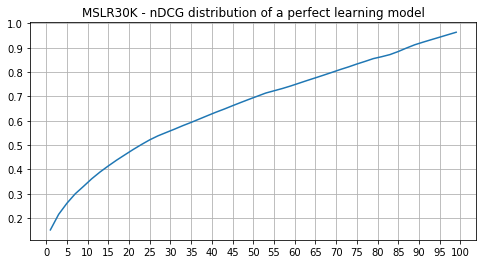

In [172]:
%%time
desc_df = distrib_df.describe()
desc_df.loc['mean', desc_df.columns.difference(['iDCG'])].plot(title='MSLR30K - nDCG distribution of a perfect learning model',
    figsize=(8,4), grid=True, xticks=range(0,101,5))

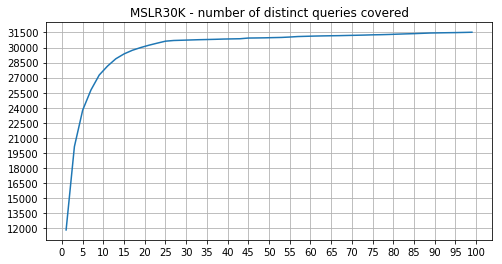

In [173]:
desc_df.loc['count', desc_df.columns.difference(['iDCG'])].plot(title='MSLR30K - number of distinct queries covered',
    figsize=(8,4), grid=True, xticks=range(0,101,5), yticks=range(12000, 32500, 1500), )

In [128]:
desc_df

,iDCG,1,3,5,7,9,11,13,15,17,...,81,83,85,87,89,91,93,95,97,99
count,31531.000000,11831.000000,20128.000000,23762.000000,25771.000000,27261.000000,28151.000000,28878.000000,29366.000000,29726.000000,...,31332.000000,31359.000000,31383.000000,31415.000000,31447.000000,31461.000000,31475.000000,31486.000000,31503.000000,31522.000000
mean,22.316934,0.123430,0.157634,0.176873,0.190535,0.199688,0.208015,0.214348,0.219341,0.223694,...,0.248873,0.249098,0.249442,0.250003,0.250453,0.250712,0.251041,0.251222,0.251441,0.251751
std,15.192476,0.154958,0.170885,0.177801,0.181594,0.184150,0.185729,0.186894,0.187842,0.188480,...,0.199100,0.199345,0.199513,0.199838,0.200057,0.200111,0.200283,0.200272,0.200367,0.200567
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.805419,0.000000,0.000000,0.000000,0.024428,0.031831,0.041506,0.049187,0.055778,0.061137,...,0.085251,0.085328,0.085685,0.086061,0.086210,0.086499,0.086650,0.086867,0.086957,0.087166
50%,19.676611,0.052259,0.102398,0.132009,0.150832,0.162726,0.173711,0.182391,0.188447,0.193189,...,0.218066,0.218301,0.218540,0.219221,0.219666,0.220013,0.220092,0.220304,0.220501,0.220817
75%,30.154397,0.220092,0.267777,0.293559,0.311875,0.322301,0.330902,0.338067,0.343218,0.347509,...,0.374278,0.374575,0.375129,0.375717,0.376465,0.376828,0.377221,0.377454,0.377623,0.377826
max,68.153390,0.917319,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# MSLR30K nDCG vs. Cache Distribution

In [933]:
def get_cache_score_distrib(df: pd.DataFrame, metric_type='NDCG', local=False, k=10):    
    def get_metric(m_type, k):
        m = None
        if m_type == 'NDCG':
            m = pyltr.metrics.NDCG(k=k)
        elif m_type == 'DCG':
            m = pyltr.metrics.DCG(k=k)
        return m
    
    metric = get_metric(metric_type, k)
    df = df.sort_values(by='Efreq', ascending=False)
    distrib = pd.Series()
    for i in range(100,0,-1):
        # CAUTION! In the first run, metric.calc_mean sets IDCG of the metric and it's used if metric is not initialized every time. 
        if local:
            metric = get_metric(metric_type, k)
        sz = int((i/100) * df.shape[0])        
        ts = df[:sz].sort_values(by='Eqids')
        distrib.loc[i] = metric.calc_mean(qids=ts['Eqids'].values, targets=ts['Ey'].values, preds=ts['Epred'].values)    
    return distrib

In [934]:
# pred_df = pd.read_csv('{}/{}-lambda_preds_{}.csv'.format(bp, r, stp_after), 
#                       dtype={'Eqids': str, 'Efreq': int, 'Ey': float, 'Epred': float})
pred_df = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-lambda_preds_urlpop_10.csv', 
                      dtype={'Eqids': str, 'Efreq': int, 'Ey': float, 'Epred': float})

In [935]:
%%time
mslr_cache_distribs = pd.DataFrame(index=list(range(1,101)))
mslr_cache_distribs['NDCG-global'] = get_cache_score_distrib(pred_df, metric_type='NDCG')
mslr_cache_distribs['NDCG-local'] = get_cache_score_distrib(pred_df, metric_type='NDCG', local=True)
mslr_cache_distribs['DCG-global'] = get_cache_score_distrib(pred_df, metric_type='DCG')
mslr_cache_distribs['DCG-local'] = get_cache_score_distrib(pred_df, metric_type='DCG', local=True)
mslr_cache_distribs.to_csv('{}/{}-cache_scoring_distributions.csv'.format(bp, r, stp_after))

CPU times: user 1h 28min 16s, sys: 5min 2s, total: 1h 33min 19s
Wall time: 25min 10s


In [936]:
mslr_cache_distribs2 = mslr_cache_distribs.copy(deep=True)

mslr_cache_distribs2

,NDCG-global,NDCG-local,DCG-global,DCG-local
1,0.046043,0.236218,1.570168,1.570168
2,0.064811,0.289362,2.137332,2.137332
3,0.077545,0.319467,2.476059,2.476059
4,0.088003,0.343073,2.731769,2.731769
5,0.095457,0.357870,2.911841,2.911841
6,0.102264,0.369973,3.053806,3.053806
7,0.107965,0.378612,3.163427,3.163427
8,0.113545,0.387504,3.274756,3.274756
9,0.119094,0.397007,3.387308,3.387308
10,0.122922,0.403493,3.450798,3.450798


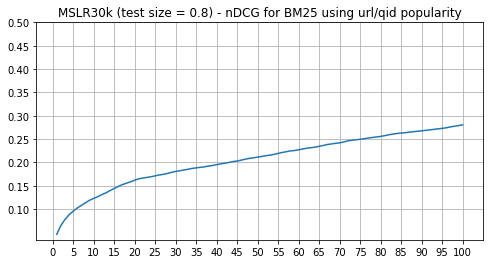

In [938]:
mslr_cache_distribs2['NDCG-global'].plot(title='MSLR30k (test size = {}) - nDCG for L2R'.format(1-2*r),
    figsize=(8,4), grid=True, xticks=range(0,101,5), yticks=(0.1,0.15,0.2,0.25,0.3,0.35,0.4, 0.45, 0.5))

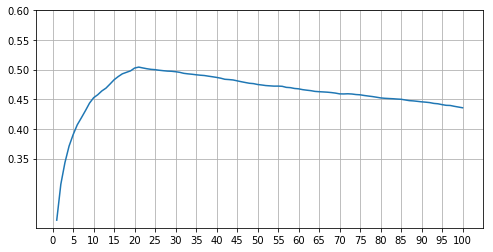

In [915]:
mslr_cache_distribs2['NDCG-local'].plot(figsize=(8,4), grid=True, xticks=range(0,101,5), yticks=(0.35,0.4,0.45,0.5,0.55,0.6))

# Duplicated Answers

In [1050]:
mslr = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/mslr-web30k.csv', index_col=0)
# mslr = pd.read_csv('/data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test_url_idpop.csv')

In [1066]:
print('all answers:', mslr.shape[0])
print('unique qureies:',len(mslr.qid.unique()))
print('unique answers:',mslr.shape[0] - mslr[mslr.duplicated(subset=dup_set)].shape[0])
dup_df = mslr[mslr.duplicated(keep=False, subset=dup_set)]
print('distinct duplicated:',dup_df[~dup_df.duplicated(subset=dup_set)].shape[0])
dup_rel_df = dup_df[dup_df['rel']>0]
print('distinct duplicated and relevant:', dup_rel_df[~dup_rel_df.duplicated(subset=dup_set)].shape[0])

all answers: 3015730
unique qureies: 25225
unique answers: 2623034
distinct duplicated: 230680
distinct duplicated and relevant: 172269


In [1067]:
dup_set = list(range(126, 134)) + [135]
dup_set = list(map(lambda x: '{}'.format(x), dup_set))
dup_df = mslr[mslr.duplicated(keep=False, subset=dup_set)]
dup_df = dup_df.copy()
dup_df['rel'] = np.where(dup_df['rel']>1, 1, 0)

In [1068]:
%%time
dup_gp = dup_df.groupby(by=dup_set)
dist = []
for name, group in dup_gp:
    dist += [(group.iloc[0]['135'], group.shape[0], group['rel'].mean())]    

CPU times: user 3min 12s, sys: 7.89 s, total: 3min 20s
Wall time: 2min 53s


In [1070]:
dist.sort(reverse=True)
dist_df = pd.DataFrame(data=dist, columns=['pagecount', 'doccount', 'mean-rel'])

In [1071]:
dist_df.corr()

,pagecount,doccount,mean-rel
pagecount,1.000000,0.997496,0.003236
doccount,0.997496,1.000000,0.002126
mean-rel,0.003236,0.002126,1.000000


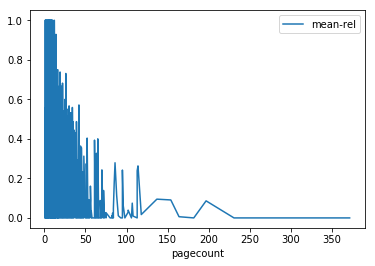

In [1072]:
dist_df.plot(x='pagecount', y='mean-rel')

In [1073]:
dist_df['relcount'] = dist_df['doccount']*dist_df['mean-rel']

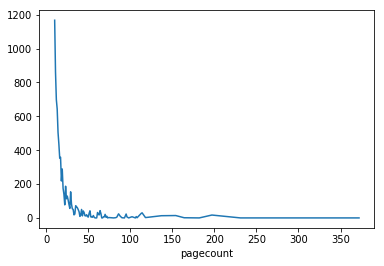

In [1074]:
dist_df.groupby('pagecount')['relcount'].sum()[10:10000].plot()

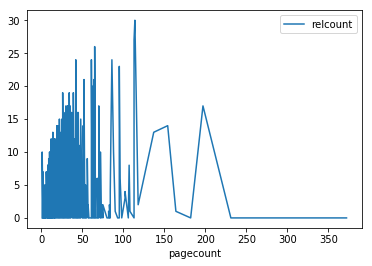

In [1075]:
dist_df.plot(x='pagecount', y='relcount')

In [1076]:
%%time
mslr_gp2 = mslr[mslr['rel'] > 0].groupby(by=dup_set)
url_count_ser = mslr_gp2.qid.count()

CPU times: user 22.5 s, sys: 1.87 s, total: 24.3 s
Wall time: 4.73 s


In [1077]:
url_count_ser.shape[0]

1313672

55

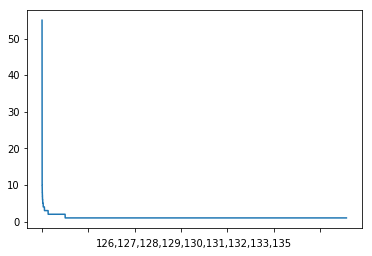

In [1078]:
url_count_ser = url_count_ser.sort_values(ascending=False)
url_count_ser.plot()
url_count_ser.iloc[0]

In [1079]:
mslr.shape

(3015730, 139)

In [1080]:
sum(mslr.duplicated(subset=dup_set))

392696

# Evaluation @k

In [1]:
import os
import pandas as pd
import numpy as np
from functools import partial

K = 10
r = 0.1
bp = '/data/khodadaa/mslr/MSLR-WEB30K/Fold1'
test_url_filename = bp + '/{}-test-UrlDistribution.csv'.format(r) # This file holds 'id','count','paired-qids','relevant-qids'
lambdamart_predictions = bp + '/{}-lambda_preds_10.csv'.format(r) # This file holds columns: 'Eqids','Epred'
test_filename = bp + '/{}-test.csv'.format(r) # This file holds columns: '110', 'rel'

## Function Definition

In [2]:
def dcg(rels:list, k):
        from math import log2
        dcg = 0.0
        for i in range(min(k, len(rels))):
            dcg += (2**rels[i] - 1) / log2((i+1) + 1)
        return dcg


def iDCG_at(df:pd.DataFrame, k, rel_col_name = 'rel'):    
    iDCG = {}
    for n, g in df.groupby('qid'):
        iDCG[n] = dcg(list(g[rel_col_name].sort_values(ascending=False)), k)
    return pd.Series(data=iDCG)
    

def nDCG_at(df:pd.DataFrame, k, iDCG:pd.Series, predictor_col_name, rel_col_name = 'rel'):
    nDCG = {}
    for n, g in df.groupby('qid'):
        if iDCG.loc[n] == 0:
            nDCG[n] = 0.0
            continue
        g = g[[predictor_col_name, rel_col_name]]
        rels = list(g.sort_values(by=predictor_col_name, ascending=False)[rel_col_name])        
        nDCG[n] = dcg(rels, k) / iDCG[n]
    return pd.Series(data=nDCG)
        

def precision_at(df:pd.DataFrame, k, predictor_col_name, y_col_name = 'y'):
    prec = {}
    for n, g in df.groupby('qid'):    
        g = g[[predictor_col_name, y_col_name]]
        p = g.sort_values(by=predictor_col_name, ascending=False)[:k][y_col_name].sum()
        prec[n] = p/k
    return pd.Series(data=prec)


def recall_at(df:pd.DataFrame, k, predictor_col_name, y_col_name = 'y'):
    recall = {}
    for n, g in df.groupby('qid'):
        g = g[[predictor_col_name, y_col_name]]
        pred_atK = g.sort_values(by=predictor_col_name, ascending=False)[:k][y_col_name].sum()
        true_atK = g[y_col_name].sort_values(ascending=False)[:k].sum()
        recall[n] = pred_atK/true_atK
    return pd.Series(data=recall)        
        

def cache_distribution(df:pd.DataFrame, evaluate_func, 
                       freq_col_name='relevant-qids', cache_size_range=range(2,101, 2)):
    df = df.sort_values(by=freq_col_name, ascending=False)
    distrib = pd.DataFrame()
    for i in cache_size_range:                
        sz = int((i/100) * df.shape[0])        
        res_seri = evaluate_func(df[:sz])
        res_seri.name = i
        distrib = pd.concat([distrib, res_seri], axis=1)
    return distrib

precision_at_K_BM25 = partial(precision_at, k=K, predictor_col_name='110')
precision_at_K_L2R = partial(precision_at, k=K, predictor_col_name='Epred')
recall_at_K_BM25 = partial(recall_at, k=K, predictor_col_name='110')
recall_at_K_L2R = partial(recall_at, k=K, predictor_col_name='Epred')
nDCG_at_K_BM25 = partial(nDCG_at, k=K, predictor_col_name='110')
nDCG_at_K_L2R = partial(nDCG_at, k=K, predictor_col_name='Epred')

## Import and Prepare Dataset

In [3]:
%%time
df = pd.read_csv(test_url_filename, index_col=0)
tmp_df = pd.read_csv(lambdamart_predictions, usecols=['Eqids','Epred'])
df = pd.concat([df, tmp_df], axis=1)
tmp_df = pd.read_csv(test_filename, usecols=['110', 'rel'])
df = pd.concat([df, tmp_df], axis=1)
df = df[['id', 'Eqids', 'rel', '110', 'Epred', 'count', 'paired-qids', 'relevant-qids']]
df.rename(columns={'id': 'uid', 'Eqids': 'qid'}, inplace=True)

/nfs/stak/users/khodadaa/miniconda3/envs/db/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 41.8 s, sys: 5.56 s, total: 47.3 s
Wall time: 19.4 s


In [4]:
df['y'] = np.where(df['rel']>0, 1, 0)

### Dataset Overview

In [5]:
df[:4]

,uid,qid,rel,110,Epred,count,paired-qids,relevant-qids,y
0,2180111,1,2,16.766961,-0.616301,2.0,2.0,1.0,1
1,1351130,1,2,21.161666,0.284777,1.0,1.0,1.0,1
2,1936056,1,0,18.279205,-1.060331,1.0,1.0,0.0,0
3,2129776,1,2,17.531630,0.197796,1.0,1.0,1.0,1


Number of all tuples 3015730
Number of distinct qids 25225
Number of distinct uids 2623034
Average number of uid for each qid 119.39183349851338
Average number of relevant uid for each qid 58.00788899900892
Number of qids with less than 2 relevant uids 1183


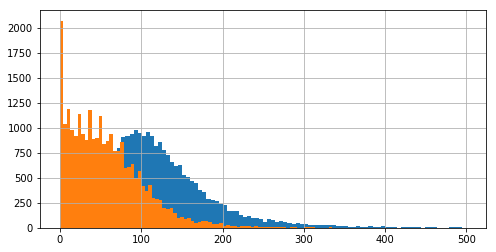

In [21]:
print('Number of all tuples', df.shape[0])
print('Number of distinct qids', df.qid.unique().shape[0])
print('Number of distinct uids', df.uid.unique().shape[0])
print('Average number of uid for each qid', df.groupby('qid')['uid'].nunique().mean())
print('Average number of relevant uid for each qid', df.groupby('qid')['y'].sum().mean())
qid_unq_uid_distrib = df.groupby('qid')['uid'].nunique()
qid_rel_uid_distrib = df.groupby('qid')['y'].sum()
print('Number of qids with less than 2 relevant uids', qid_rel_uid_distrib[qid_rel_uid_distrib<2].shape[0])
qid_unq_uid_distrib[qid_unq_uid_distrib <500].hist(bins=100, figsize=(8,4))
qid_rel_uid_distrib[qid_rel_uid_distrib<500].hist(bins=100, figsize=(8,4))

## Precision

### BM25 - Precision

In [7]:
%%time
print('K', K)
filename = bp + '/{}-test-p{}-BM25-verbose.csv'.format(r, K)
if os.path.exists(filename):
    print('Reading {} ...'.format(filename))
    dist_BM25_precision = pd.read_csv(filename, index_col=0)
    dist_BM25_precision.columns = dist_BM25_precision.columns.astype(int)
else:
    print('Generating {} ...'.format(filename))
    dist_BM25_precision = cache_distribution(df, evaluate_func=precision_at_K_BM25)
    dist_BM25_precision.to_csv(filename)

K 10
Reading /data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test-p10-BM25-verbose.csv ...
CPU times: user 131 ms, sys: 4.04 ms, total: 135 ms
Wall time: 133 ms


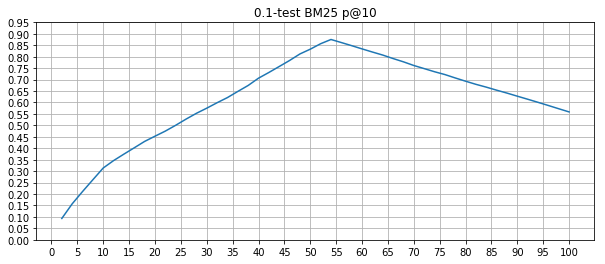

In [8]:
dist_BM25_precision.fillna(0).mean().plot(title='{}-test BM25 p@{}'.format(r, K),
    figsize=(10,4), grid=True, xticks=range(0,101,5), yticks=[i/100 for i in range(0,100,5)])

### L2R - Precision

In [9]:
%%time
print('K', K)
filename = bp + '/{}-test-p{}-L2R-verbose.csv'.format(r, K)
if os.path.exists(filename):
    print('Reading {} ...'.format(filename))
    dist_L2R_precision = pd.read_csv(filename, index_col=0)
    dist_L2R_precision.columns = dist_L2R_precision.columns.astype(int)
else:
    print('Generating {} ...'.format(filename))
    dist_L2R_precision = cache_distribution(df, evaluate_func=precision_at_K_L2R)
    dist_L2R_precision.to_csv(filename)

K 10
Reading /data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test-p10-L2R-verbose.csv ...
CPU times: user 138 ms, sys: 5.98 ms, total: 144 ms
Wall time: 143 ms


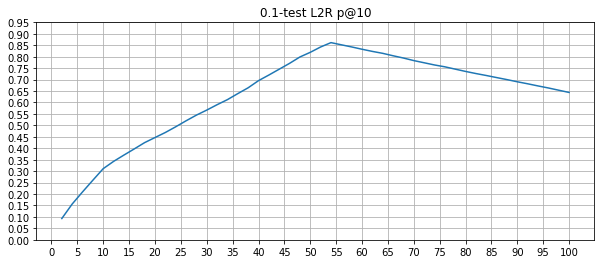

In [10]:
dist_L2R_precision.fillna(0).mean().plot(title='{}-test L2R p@{}'.format(r, K),
    figsize=(10,4), grid=True, xticks=range(0,101,5), yticks=[i/100 for i in range(0,100,5)])

## Recall

### BM25 - Recall

In [11]:
%%time
print('K', K)
filename = bp + '/{}-test-r{}-BM25-verbose.csv'.format(r, K)
if os.path.exists(filename):
    print('Reading {} ...'.format(filename))
    dist_BM25_recall = pd.read_csv(filename, index_col=0)
    dist_BM25_recall.columns = dist_BM25_recall.columns.astype(int)
else:
    print('Generating {} ...'.format(filename))
    dist_BM25_recall = cache_distribution(df, evaluate_func=recall_at_K_BM25)
    dist_BM25_recall.to_csv(filename)

K 10
Reading /data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test-r10-BM25-verbose.csv ...
CPU times: user 140 ms, sys: 1.13 ms, total: 141 ms
Wall time: 140 ms


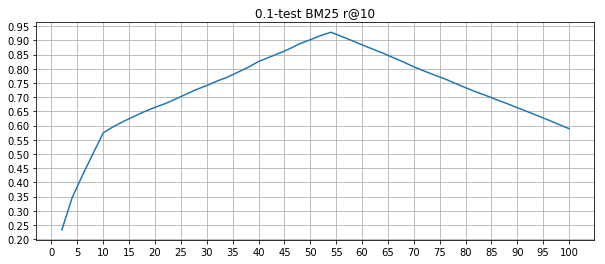

In [12]:
dist_BM25_recall.fillna(0).mean().plot(title='{}-test BM25 r@{}'.format(r, K),
    figsize=(10,4), grid=True, xticks=range(0,101,5), yticks=[i/100 for i in range(20,100,5)])

### L2R - Recall

In [13]:
%%time
print('K', K)
filename = bp + '/{}-test-r{}-L2R-verbose.csv'.format(r, K)
if os.path.exists(filename):
    print('Reading {} ...'.format(filename))
    dist_L2R_recall = pd.read_csv(filename, index_col=0)
    dist_L2R_recall.columns = dist_L2R_recall.columns.astype(int)
else:
    print('Generating {} ...'.format(filename))
    dist_L2R_recall = cache_distribution(df, evaluate_func=recall_at_K_L2R)
    dist_L2R_recall.to_csv(filename)

K 10
Reading /data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test-r10-L2R-verbose.csv ...
CPU times: user 143 ms, sys: 2.9 ms, total: 146 ms
Wall time: 145 ms


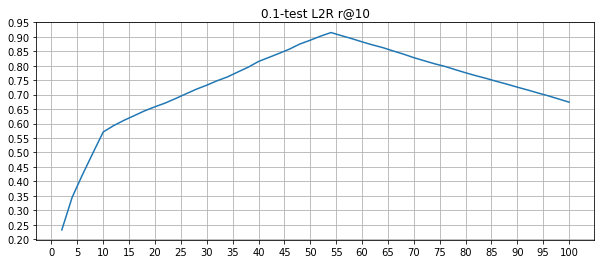

In [14]:
dist_L2R_recall.fillna(0).mean().plot(title='{}-test L2R r@{}'.format(r, K),
    figsize=(10,4), grid=True, xticks=range(0,101,5), yticks=[i/100 for i in range(20,100,5)])

## nDCG

In [15]:
%%time
# Setting global iDCG
print('K', K)
global_iDCG_at_K_Ser = iDCG_at(df, K)
nDCG_at_K_Glob_iDCG_BM25 = partial(nDCG_at_K_BM25, iDCG=global_iDCG_at_K_Ser)
nDCG_at_K_Glob_iDCG_L2R  = partial(nDCG_at_K_L2R,  iDCG=global_iDCG_at_K_Ser)

K 10
CPU times: user 14.3 s, sys: 440 ms, total: 14.7 s
Wall time: 14.7 s


### BM25 - nDCG

In [16]:
%%time
print('K', K)
filename = bp + '/{}-test-nDCG{}-BM25-verbose.csv'.format(r, K)
if os.path.exists(filename):
    print('Reading {} ...'.format(filename))
    dist_BM25_ndcg = pd.read_csv(filename, index_col=0)
    dist_BM25_ndcg.columns = dist_BM25_ndcg.columns.astype(int)
else:
    print('Generating {} ...'.format(filename))
    dist_BM25_ndcg = cache_distribution(df, evaluate_func=nDCG_at_K_Glob_iDCG_BM25)
    dist_BM25_ndcg.to_csv(filename)

K 10
Reading /data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test-nDCG10-BM25-verbose.csv ...
CPU times: user 341 ms, sys: 36.3 ms, total: 378 ms
Wall time: 385 ms


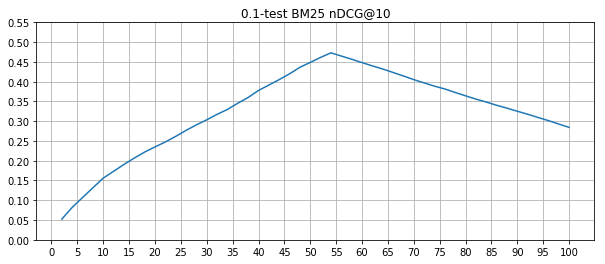

In [17]:
dist_BM25_ndcg.fillna(0).mean().plot(title='{}-test BM25 nDCG@{}'.format(r, K),
    figsize=(10,4), grid=True, xticks=range(0,101,5), yticks=[i/100 for i in range(0,60,5)])

### L2R - nDCG

In [18]:
%%time
print('K', K)
filename = bp + '/{}-test-nDCG{}-L2R-verbose.csv'.format(r, K)
if os.path.exists(filename):
    print('Reading {} ...'.format(filename))
    dist_L2R_ndcg = pd.read_csv(filename, index_col=0)
    dist_L2R_ndcg.columns = dist_L2R_ndcg.columns.astype(int)
else:
    print('Generating {} ...'.format(filename))
    dist_L2R_ndcg = cache_distribution(df, evaluate_func=nDCG_at_K_Glob_iDCG_L2R)
    dist_L2R_ndcg.to_csv(filename)

K 10
Reading /data/khodadaa/mslr/MSLR-WEB30K/Fold1/0.1-test-nDCG10-L2R-verbose.csv ...
CPU times: user 460 ms, sys: 14.8 ms, total: 475 ms
Wall time: 473 ms


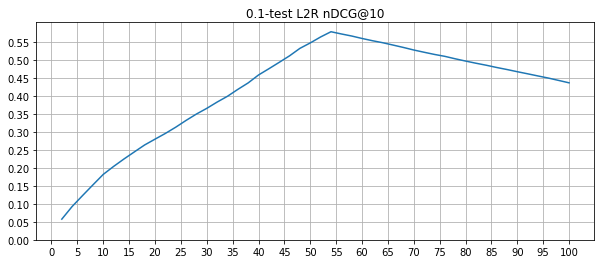

In [19]:
dist_L2R_ndcg.fillna(0).mean().plot(title='{}-test L2R nDCG@{}'.format(r, K),
    figsize=(10,4), grid=True, xticks=range(0,101,5), yticks=[i/100 for i in range(0,60,5)])

## Save combined results

In [20]:
print('K', K)
result_df = pd.concat([dist_L2R_precision.fillna(0).mean(),
           dist_L2R_recall.fillna(0).mean(),
           dist_L2R_ndcg.fillna(0).mean(),
           dist_BM25_precision.fillna(0).mean(),
           dist_BM25_recall.fillna(0).mean(),
           dist_BM25_ndcg.fillna(0).mean()],
          axis=1).rename(columns={0:'L2R-p@{}'.format(K), 1:'L2R-r@{}'.format(K), 2:'L2R-nDCG@{}'.format(K),
                                  3:'BM25-p@{}'.format(K), 4:'BM25-r@{}'.format(K), 5:'BM25-nDCG@{}'.format(K)})

result_df.to_csv(bp + '/{}-results_caching.csv'.format(r), index=False)

K 10
